In [142]:
import objective_functions as of
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import contour_stepper as cs


dataset_name = 'HD. Human Hair 25'

directory = '../results'
depthmap_method = 'FIJI.tif'
texture_method = 'ZS.jpg'


#input_texture_path = f'{dir}/{dataset_name}/Texture-{texture_method}'
input_texture_path = f'../datasets/20-Simple/frame73.jpg'
glob_threshold = 2

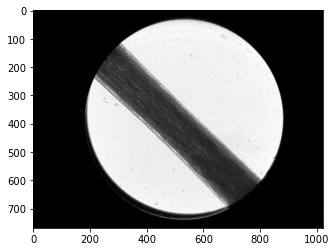

In [2]:
texture = cv.imread(input_texture_path, cv.IMREAD_COLOR)

# preprocess the texture
grayscale_texture = cv.cvtColor(texture, cv.COLOR_RGB2GRAY)
plt.imshow(grayscale_texture, cmap='gray')

In [3]:
# get the black background mask in order to afterwards transform the black background to
# be in the same cluster in Otsu's binarization as the bright one
threshold, black_background_mask = cv.threshold(grayscale_texture, glob_threshold, 255, cv.THRESH_BINARY_INV)

# find the brightest pixel - it will be used as a bright background value
minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(grayscale_texture)

# making sure that grayscaled_texture (<glob_threshold) + 255 * coeff < 255
coeff = np.min([maxVal / 255, 1 - glob_threshold / 255])

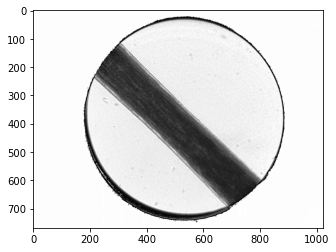

In [4]:
# adding 255 * coeff to the black background to set it bright
grayscale_texture = cv.addWeighted(grayscale_texture, 1, black_background_mask, coeff, 0)
plt.imshow(grayscale_texture, cmap='gray')

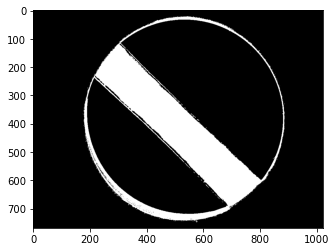

In [5]:
# apply otsu's binarization to the texture
th, mask = cv.threshold(grayscale_texture, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(mask, cmap='gray')

# apply mask to the depthmap and save the result
# masked_depth_map = cv.bitwise_and(depth_map, depth_map, mask=mask)
# cv.imwrite(output_depthmap_path, masked_depth_map)

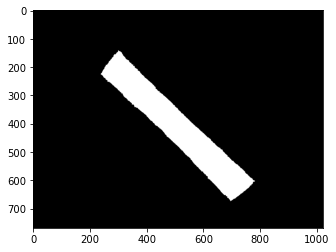

In [6]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv.erode(mask, kernel, iterations=6)
plt.imshow(erosion, cmap='gray')

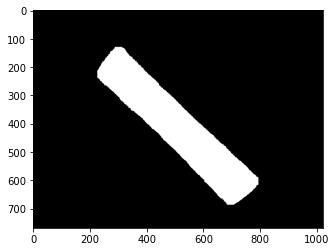

In [7]:
dilation = cv.dilate(erosion, kernel, iterations=6)
plt.imshow(dilation, cmap='gray')
mask = dilation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

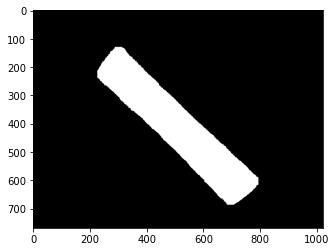

In [8]:
# also: cv2.Canny
contour = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
#black[:, :] = (55, 55, 55)
# не очень понимаю, как это всё работает и почему приходится делать absdiff <- это старое, сейчас всёё понимаю!
contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
plt.imshow(mask, cmap='gray')

cv.drawContours(contour, contours, -1, (255, 255, 255), 1)

In [ ]:
plt.imshow(contour, cmap='gray')

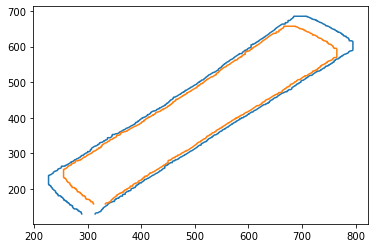

In [151]:
raw_contour = contours[0].reshape(-1, 2)
contour_mass_centre = np.mean(np.array(contours[0]), axis=0).astype(int)
scale_range = 0.9

smaller_contour = (scale_range * (raw_contour - contour_mass_centre)).astype(int) \
    + contour_mass_centre

plt.plot(raw_contour[:, 0], raw_contour[:, 1])
plt.plot(smaller_contour[:, 0], smaller_contour[:, 1])

In [152]:
# raw_contour = smaller_contour
# cntr = np.array([[1, 1], [2, 1], [2, 2], [4, 4], [5, 6], [4, 1]])
# centre = np.array([500, 500])
# raw_contour = raw_contour + contour_mass_centre
diffs = contour_mass_centre - raw_contour
maxes = np.amax(np.abs(diffs), axis=1, keepdims=True)
smallest_steps = np.divide(diffs, maxes)
raw_contour = np.append(raw_contour, smallest_steps, axis=1)
raw_contour = np.append(raw_contour, maxes, axis=1)

In [153]:
window_size = 21
max_w = grayscale_texture.shape[1]
max_h = grayscale_texture.shape[0]

raw_contour_step = []
for contour_point in raw_contour:
    inner_points = np.array(contour_point[0:2], ndmin=2).transpose() +\
             np.array(contour_point[2:4], ndmin=2).transpose() *\
             np.tile(np.array(range(1, contour_point[4].astype(int) + 1)), (2, 1))
    inner_points = inner_points.transpose()

    focus_measure_values = []
    for inner_point in inner_points:
        inner_point = inner_point.astype(int)
        lower_x = max(0, inner_point[0] - (window_size - 1) // 2)
        upper_x = min(max_w, inner_point[0] + (window_size - 1) // 2) + 1
        lower_y = max(0, inner_point[1] - (window_size - 1) // 2)
        upper_y = min(max_h, inner_point[1] + (window_size - 1) // 2) + 1

        focus_measure_values.append(of.LAPM(grayscale_texture[lower_y:upper_y, lower_x:upper_x]))
    (point_x, point_y) = inner_points[np.argmax(focus_measure_values)].astype(int)
    raw_contour_step.append([point_x, point_y])
#print(np.array([1, 1], ndmin=2).transpose() + np.array([2, 2], ndmin=2).transpose() * np.tile(np.array(range(1, 5)), (2, 1)))

(774, 2)


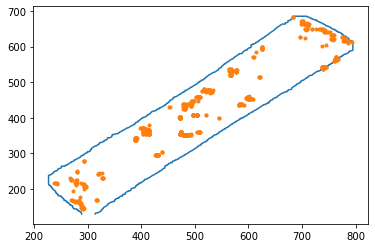

In [154]:
raw_contour_step = np.array(raw_contour_step)
print(np.array(raw_contour_step).shape)
plt.plot(raw_contour[:, 0], raw_contour[:, 1])
plt.plot(raw_contour_step[:, 0], raw_contour_step[:, 1], '.')

289
289
289
288
287
286
285
284
284
283
282
282
281
280
280
279
276
274
274
273
272
271
270
270
269
267
267
266
266
264
263
263
262
261
262
261
260
260
259
257
257
256
256
254
254
253
252
252
251
251
250
246
246
245
245
244
243
243
242
243
241
241
237
237
235
235
234
233
232
232
231
230
229
229
228
228
229
231
232
282
304
250
251
250
251
250
246
247
261
261
278
260
273
259
274
273
274
273
274
274
275
273
272
275
277
275
277
281
281
280
281
283
283
290
291
290
289
289
307
305
326
305
308
305
303
301
302
301
306
359
307
310
311
310
318
316
315
316
317
320
326
327
327
326
326
326
326
328
340
343
340
343
344
360
416
371
416
359
355
351
355
359
357
359
360
362
360
368
369
370
370
377
378
379
380
384
384
387
388
389
389
411
396
392
393
393
394
394
395
416
416
398
398
405
405
405
407
407
408
408
413
414
414
414
415
421
419
421
434
424
424
425
426
427
428
446
431
431
432
433
436
437
438
437
441
442
445
445
446
447
448
450
449
450
453
452
463
464
464
504
504
504
472
465
467
460
461
463
466
466


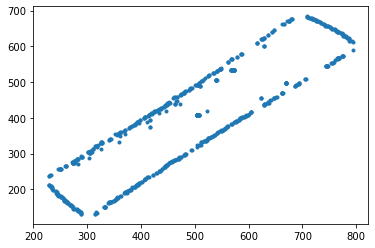

In [147]:
raw_contour = contours[0].reshape(-1, 2)
raw_next_contour = np.array(cs.next_contour(grayscale_texture, raw_contour, contour_mass_centre))
plt.plot(raw_next_contour[:, 0], raw_next_contour[:, 1], '.')

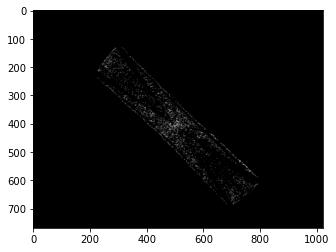

In [149]:
input_directory_path = f'../datasets/20/'
glob_threshold = 2

depthmap = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
for i in range(54, 85):
    input_texture_path = input_directory_path + 'frame' + str(i) + '.jpg'
    texture = cv.imread(input_texture_path, cv.IMREAD_COLOR)

    # preprocess the texture
    grayscale_texture = cv.cvtColor(texture, cv.COLOR_RGB2GRAY)
    plt.imshow(grayscale_texture, cmap='gray')

    raw_next_contour = np.array(cs.next_contour(grayscale_texture, raw_contour, contour_mass_centre))
    for (point_x, point_y) in raw_next_contour:
        depthmap[point_y, point_x] = (i - 54) * 8

plt.imshow(depthmap, cmap='gray')

In [150]:
cv.imwrite(r'../results/depthmap.jpg', depthmap)

True

In [ ]:
# window_size = 23 #better be odd
# contour_step = np.zeros((grayscale_texture.shape[0], grayscale_texture.shape[1]), np.uint8)
#
# for i in range(1, contour.shape[0]):
#     for j in range(1, contour.shape[1]):
#         if contour[i - 1, j - 1] > 0:
#             # приращение
#             dw = w_mass - j
#             dh = h_mass - i
#
#             # в теории контур может пройти через центр масс => скипаем
#             if dw == 0 and dh == 0:
#                 continue
#
#             # нормируем приращение, чтобы (y + dh, x + dw) было новым следующим пикселем
#             max_d = max(abs(dw), abs(dh))
#             dw /= max_d
#             dh /= max_d
#
#             # k - сколько шагов между (х, y) и центром масс нужно сделать. Да, тут можно просто max_d взять, но раньше
#             #   была идея рассматривать всю доступную прямую -- осталось с тех времён, вдруг понадобится.
#             # x_bound_1, y_bound_1 - ограничения на k снизу при приращении ширины и высоты, соответственно.
#             # x_bound_2, y_bound_2 - ограничения на k сверху.
#
#             if dw == 0:
#                 x_bound_1 = 0
#                 x_bound_2 = contour.shape[1]
#             else:
#                 # рассматриваем только отрезок между пикселем и центром масс, не всю прямую
#                 x_bound_1 = min(0, (w_mass - j) / dw)
#                 x_bound_2 = max(0, (w_mass - j) / dw)
#                 # x_bound_1 = min(-j / dw, (contour.shape[1] - 1 - j) / dw)
#                 # x_bound_2 = max(-j / dw, (contour.shape[1] - 1 - j) / dw)
#
#             if dh == 0:
#                 y_bound_1 = 0
#                 y_bound_2 = contour.shape[0]
#             else:
#                 # рассматриваем только отрезок между пикселем и центром масс, не всю прямую
#                 y_bound_1 = min(0, (h_mass - i) / dh)
#                 y_bound_2 = max(0, (h_mass - i) / dh)
#                 #y_bound_1 = min(-i / dh, (contour.shape[0] - 1 - i) / dh)
#                 #y_bound_2 = max(-i / dh, (contour.shape[0] - 1 - i) / dh)
#
#             min_k = np.int16(np.ceil(max(x_bound_1, y_bound_1))) # min k: x + k * dw >= 0, y + k * dh >= 0
#             max_k = np.int16(np.floor(min(x_bound_2, y_bound_2))) # max k: ...
#
#             fm_results = np.zeros(max_k - min_k + 1)
#             for k in range(min_k, max_k + 1):
#                 x = np.int16(np.floor(j + k * dw))
#                 y = np.int16(np.floor(i + k * dh))
#
#                 lower_x = max(0, x - (window_size - 1) // 2)
#                 upper_x = min(contour.shape[1], x + (window_size - 1) // 2)
#                 lower_y = max(0, y - (window_size - 1) // 2)
#                 upper_y = min(contour.shape[0], y + (window_size - 1) // 2)
#
#                 # print(lower_x, upper_x, lower_y, upper_y)
#                 fm_results[k - min_k] = of.LAPM(grayscale_texture[lower_y:upper_y, lower_x:upper_x])
#
#             k_max_focus = np.argmax(fm_results) + min_k
#             contour_step[np.uint16(np.floor(i + k_max_focus * dh)), np.uint16(np.floor(j + k_max_focus * dw))] = 255
#
#
#
# #print(h_mass / num, w_mass / num)
# plt.imshow(contour_step, cmap='gray')
#

In [ ]:
# plt.imshow(contour, cmap='gray')
# #lines = cv.HoughLines(contour, 1, np.pi / 180, threshold=300)
#
#

In [ ]:
# cont = np.add(contour, contour_step)
# plt.imshow(np.add(contour, contour_step), cmap='gray')

